# Generation and post-analysis in aids dataset 

#### Associated publication
Reference: https://www.nejm.org/doi/full/10.1056/NEJM199709113371101

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tableone import TableOne
import torch
from sksurv.nonparametric import kaplan_meier_estimator
import os
import sys
from pathlib import Path
module_path = Path.cwd().parent / 'utils'
sys.path.append(str(module_path))
import data_processing, visualization

module_path = Path.cwd().parent / 'execute'
sys.path.append(str(module_path))

from synthcity.metrics.plots import plot_tsne
from synthcity.metrics.eval import Metrics
from synthcity.metrics.scores import ScoreEvaluator
from synthcity.plugins.core.dataloader import SurvivalAnalysisDataLoader
from synthcity.utils.reproducibility import clear_cache, enable_reproducible_results

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


## 1. Original data loading, analysis and visualization

### 1.1. Experiment setting - links to data

In [2]:
dataset_name = "SAS_3"
current_path = os.getcwd()  # Get current working directory
parent_path = os.path.dirname(current_path)
data_file_control= parent_path + "/dataset/" + dataset_name + "/data_control.csv"
feat_types_file_control = parent_path + "/dataset/" + dataset_name + "/data_types_control.csv"
data_file_treated= parent_path + "/dataset/" + dataset_name + "/data_treated.csv"
feat_types_file_treated= parent_path + "/dataset/" + dataset_name + "/data_types_treated.csv"

# If the dataset has no missing data, leave the "miss_file" variable empty
m_perc = 10
mask = 1
miss_file = parent_path + "/dataset/" + dataset_name + "/Missing{}_{}.csv".format(m_perc, mask)
true_miss_file = None

### 1.2. Loading, feature analysis, and visualization of original data: control vs treated group

In [3]:
control_fnames = ['time', 'censor'] + pd.read_csv(feat_types_file_control)["name"].to_list()[1:]
control = pd.read_csv(data_file_control, header=None, names=control_fnames)
print(control.head())

    time  censor  SEX   AGE  RACE  PRHNTRTC  CARBOADD  CARBO2D  B_ECOG  \
0  984.0     1.0    0  21.0     4         1         0        0       0   
1  214.0     1.0    1  21.0     4         1         0        0       2   
2  218.0     0.0    0  23.0     4         1         0        0       2   
3  242.0     1.0    1  26.0     4         0         0        0       2   
4   55.0     1.0    1  26.0     4         1         0        0       2   

   DIAGTYPE  
0         3  
1         3  
2         0  
3         3  
4         3  


In [4]:
# Load and transform control data
data_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, 
                                                                                                             feat_types_file_control, 
                                                                                                             miss_file, true_miss_file)

In [5]:
# Load and transform control data
df_init_control_encoded, feat_types_dict, miss_mask_control, true_miss_mask_control, _ = data_processing.read_data(data_file_control, feat_types_file_control, miss_file, true_miss_file)
data_init_control_encoded = torch.from_numpy(df_init_control_encoded.values)
data_init_control = data_processing.discrete_variables_transformation(data_init_control_encoded, feat_types_dict)

# Load and transform treated data
df_init_treated_encoded, _, _, _, _ = data_processing.read_data(data_file_treated, feat_types_file_treated, miss_file, true_miss_file)
data_init_treated_encoded = torch.from_numpy(df_init_treated_encoded.values)
data_init_treated = data_processing.discrete_variables_transformation(data_init_treated_encoded, feat_types_dict)

In [6]:
# Format data in dataframe
df_init_treated = pd.DataFrame(data_init_treated.numpy(), columns=control_fnames)
df_init_control = pd.DataFrame(data_init_control.numpy(), columns=control_fnames)

# Update the data
df_init_treated["treatment"] = 1
df_init_control["treatment"] = 0
df_init = pd.concat([df_init_control, df_init_treated], ignore_index=True)

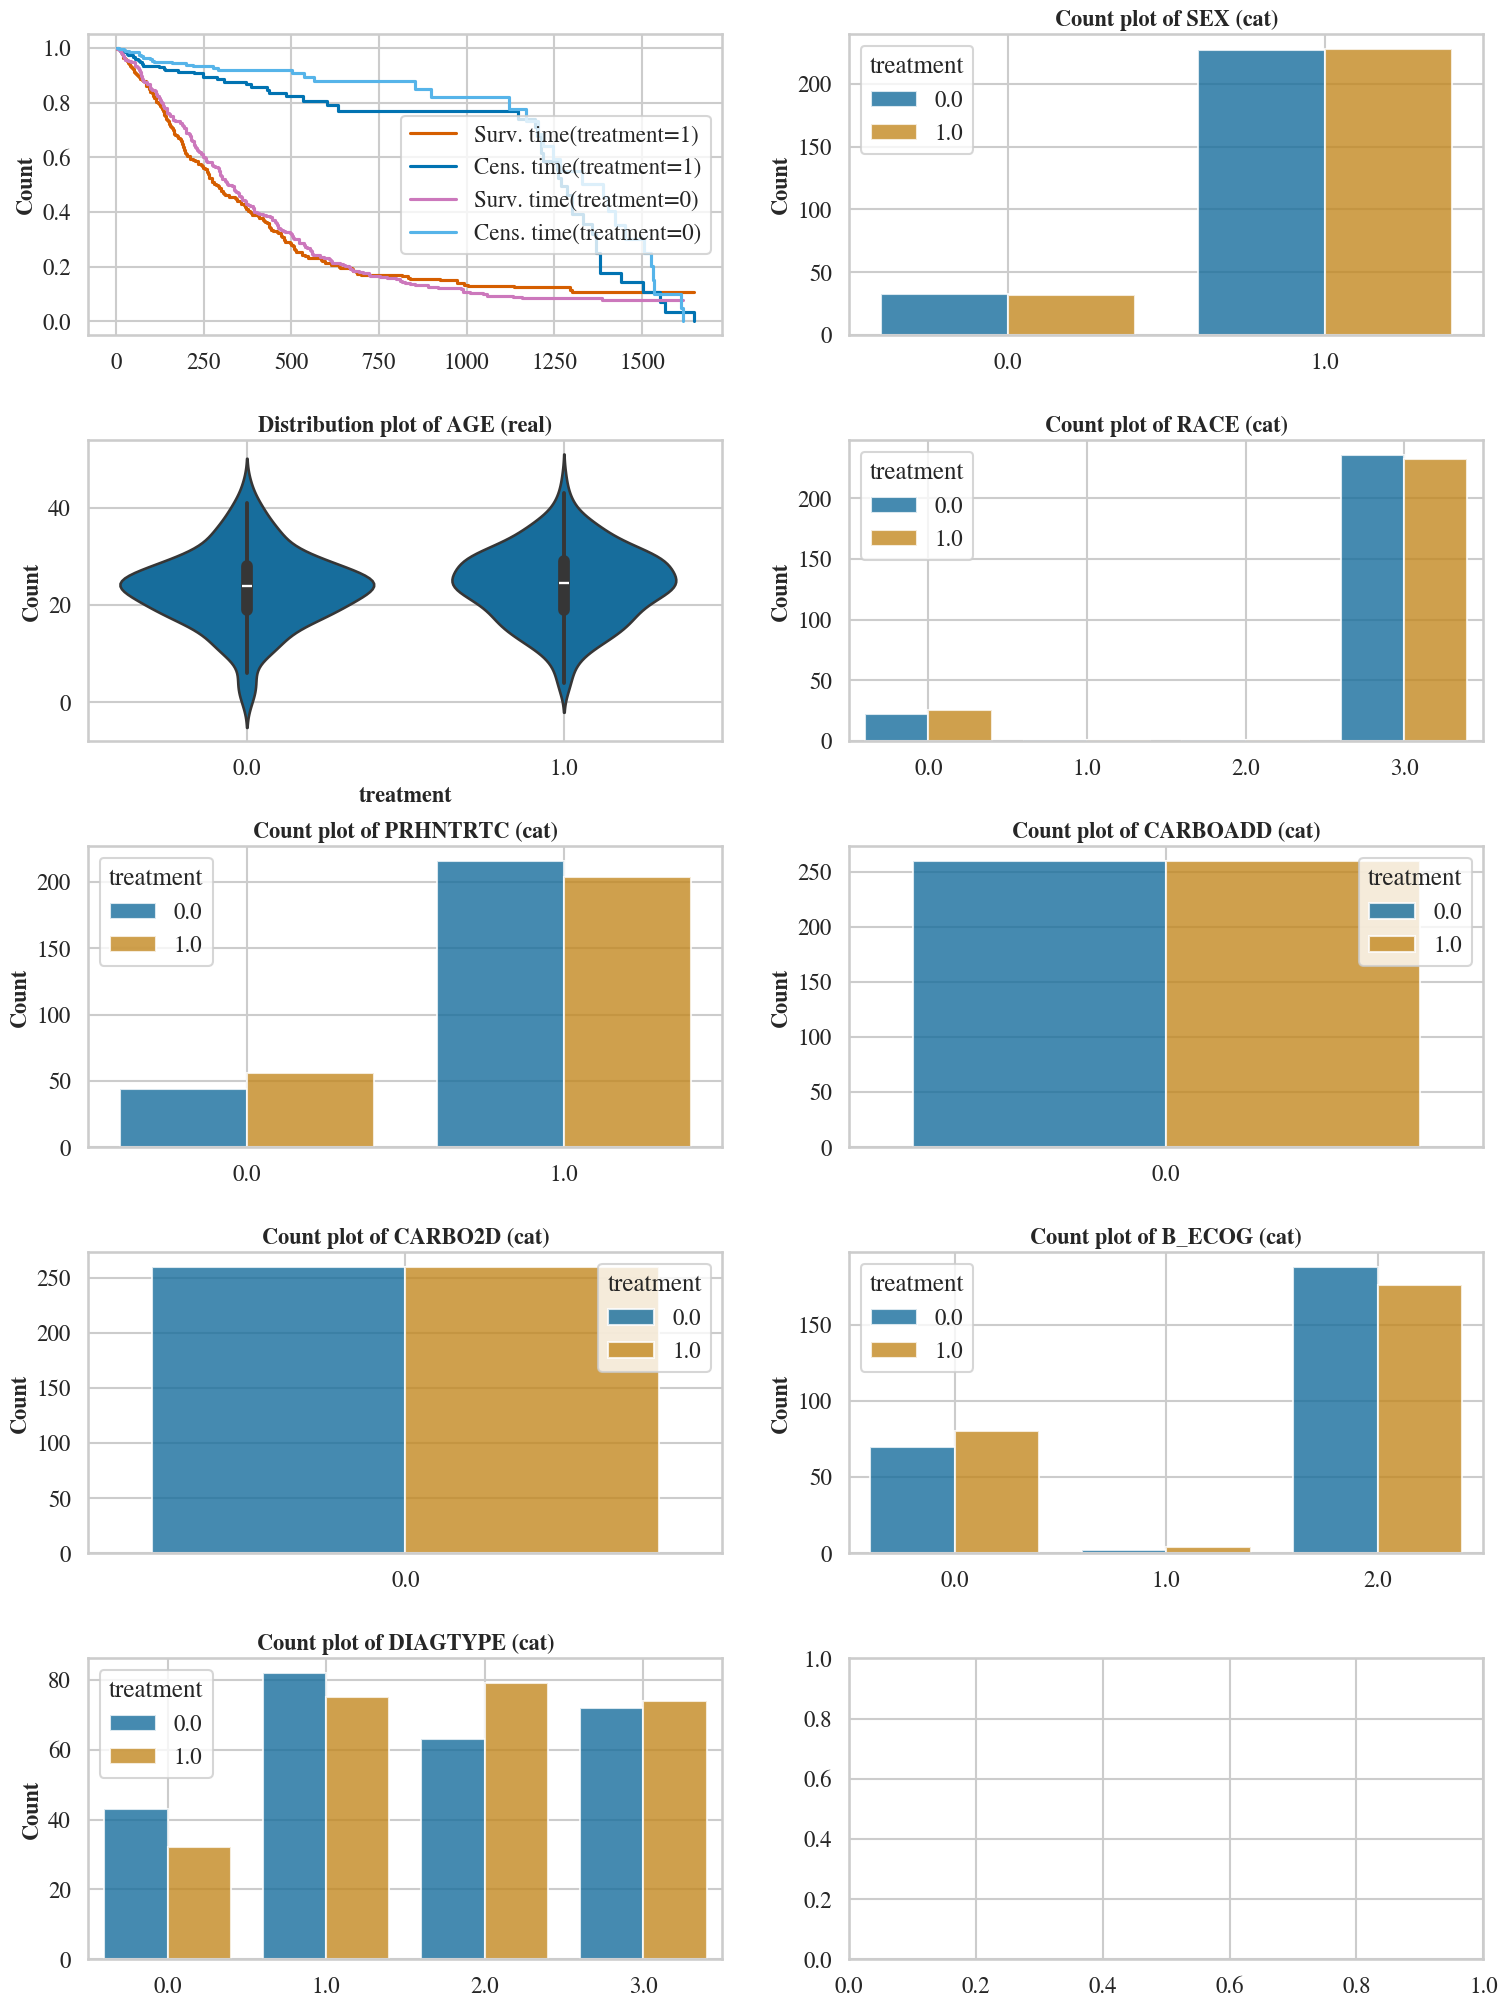

In [7]:
# TODO: Refactor
feat_types_dict_all = feat_types_dict.copy()
feat_types_dict_all.append({'name': 'treatment', 'type': 'cat', 'dim': '1', 'nclass': '2'})
visualization.plot_data(df_init.to_numpy(), feat_types_dict_all, feat_comparison_name='treatment')

In [8]:
categorical = ['censor', 'SEX', 'RACE', 'PRHNTRTC', 'CARBOADD', 'CARBO2D', 'B_ECOG', 'DIAGTYPE']
continuous = ['time', 'AGE']
nonnormal = ['time']

table1 = TableOne(df_init, categorical=categorical, continuous=continuous, 
                  groupby='treatment', nonnormal=nonnormal, pval=True)
print(table1)

                         Grouped by treatment                                                                       
                                      Missing              Overall                    0                    1 P-Value
n                                                              520                  260                  260        
time, median [Q1,Q3]                        0  273.5 [127.5,507.2]  296.0 [133.8,536.5]  252.0 [119.2,480.5]   0.109
censor, n (%)        0.0                                 95 (18.3)            39 (15.0)            56 (21.5)   0.069
                     1.0                                425 (81.7)           221 (85.0)           204 (78.5)        
SEX, n (%)           0.0                                 65 (12.5)            33 (12.7)            32 (12.3)   1.000
                     1.0                                455 (87.5)           227 (87.3)           228 (87.7)        
AGE, mean (SD)                              0           23.8 (7.

## 2. Training and generation from the generative model

Possible generative models: HI-VAE (our), survival_gan, survival_ctgan, survival_nflow, survae (synthcity)

In [9]:
import surv_hivae

# the datasets used for training is data_init_control
n_generated_dataset = 100

In [10]:
data_gen_control = surv_hivae.run(df_init_control_encoded,
                                  miss_mask_control, 
                                  true_miss_mask_control,
                                  feat_types_dict,
                                  n_generated_dataset)

Epoch: [ 0]  time: 0.0298, ELBO_train: -10.71893263, KL_z: 1.22337878, KL_s: 0.06244648, reconstruction loss: -9.43310738
Epoch: [100]  time: 1.9462, ELBO_train: -7.32219481, KL_z: 0.23298546, KL_s: 0.01636791, reconstruction loss: -7.07284144
Epoch: [200]  time: 3.8943, ELBO_train: -6.82237148, KL_z: 0.22816332, KL_s: 0.01248491, reconstruction loss: -6.58172326
Epoch: [300]  time: 6.0477, ELBO_train: -6.72010708, KL_z: 0.26259567, KL_s: 0.01084065, reconstruction loss: -6.44667076
Epoch: [400]  time: 8.4610, ELBO_train: -6.62205935, KL_z: 0.26219170, KL_s: 0.01094806, reconstruction loss: -6.34891959
Epoch: [500]  time: 10.3538, ELBO_train: -6.59468484, KL_z: 0.28318651, KL_s: 0.00990224, reconstruction loss: -6.30159609
Epoch: [600]  time: 12.4305, ELBO_train: -6.44099092, KL_z: 0.28477605, KL_s: 0.01370645, reconstruction loss: -6.14250843
Epoch: [700]  time: 14.8046, ELBO_train: -6.70960164, KL_z: 0.33096686, KL_s: 0.01146543, reconstruction loss: -6.36716935
Epoch: [800]  time: 1

## 3. Analyze the generated data

### 3.1. Statistical analysis: one generated control group vs. initial control data

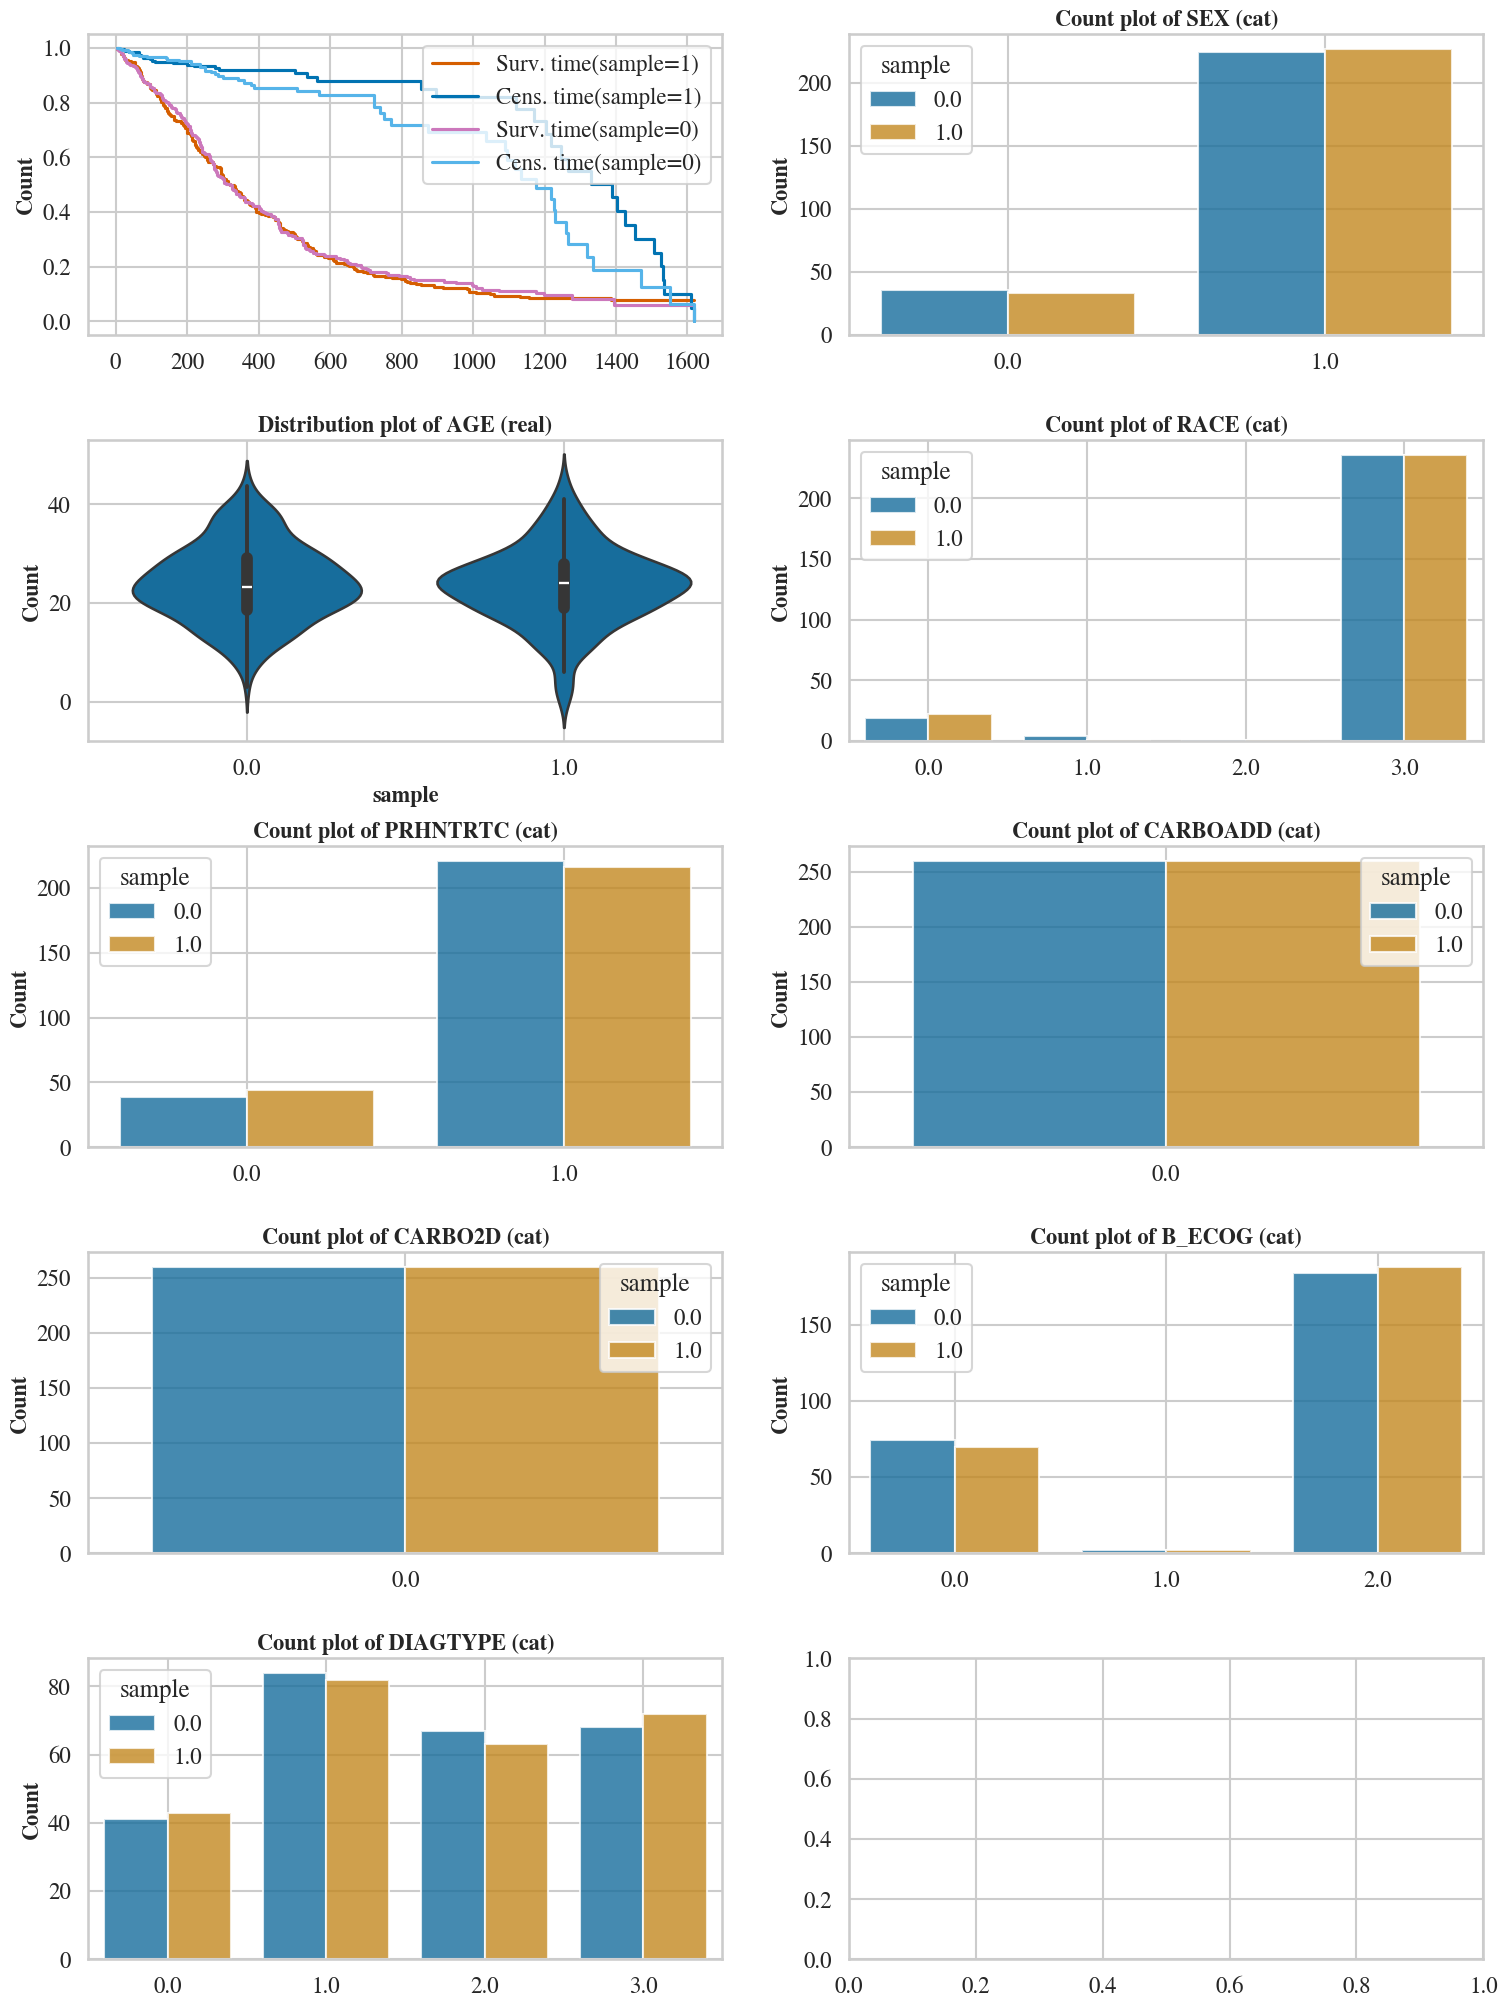

In [11]:
df_init_control_ext = pd.DataFrame(data_init_control.numpy(), columns=control_fnames)
df_init_control_ext['sample'] = 1

sel_idx = 2
df_gen_control_ext_sel = pd.DataFrame(data_gen_control[sel_idx].numpy(), columns=control_fnames)
df_gen_control_ext_sel['sample'] = 0

feat_types_dict_ext = feat_types_dict.copy()
feat_types_dict_ext.append({'name': 'sample', 'type': 'cat', 'dim': '1', 'nclass': '2'})
df_control_sel = pd.concat([df_init_control_ext, df_gen_control_ext_sel], ignore_index=True)
visualization.plot_data(df_control_sel.to_numpy(), feat_types_dict_ext, feat_comparison_name = 'sample')

In [12]:
table1 = TableOne(df_control_sel, categorical=categorical, continuous=continuous, groupby='sample', nonnormal=nonnormal, pval=True)
print(table1)

                         Grouped by sample                                                                       
                                   Missing              Overall                    0                    1 P-Value
n                                                           520                  260                  260        
time, median [Q1,Q3]                     0  288.2 [144.8,524.8]  279.2 [157.3,522.5]  296.0 [133.8,536.5]   0.919
censor, n (%)        0.0                              88 (16.9)            49 (18.8)            39 (15.0)   0.293
                     1.0                             432 (83.1)           211 (81.2)           221 (85.0)        
SEX, n (%)           0.0                              69 (13.3)            36 (13.8)            33 (12.7)   0.796
                     1.0                             451 (86.7)           224 (86.2)           227 (87.3)        
AGE, mean (SD)                           0           23.7 (7.8)           24.0 (7.8)    

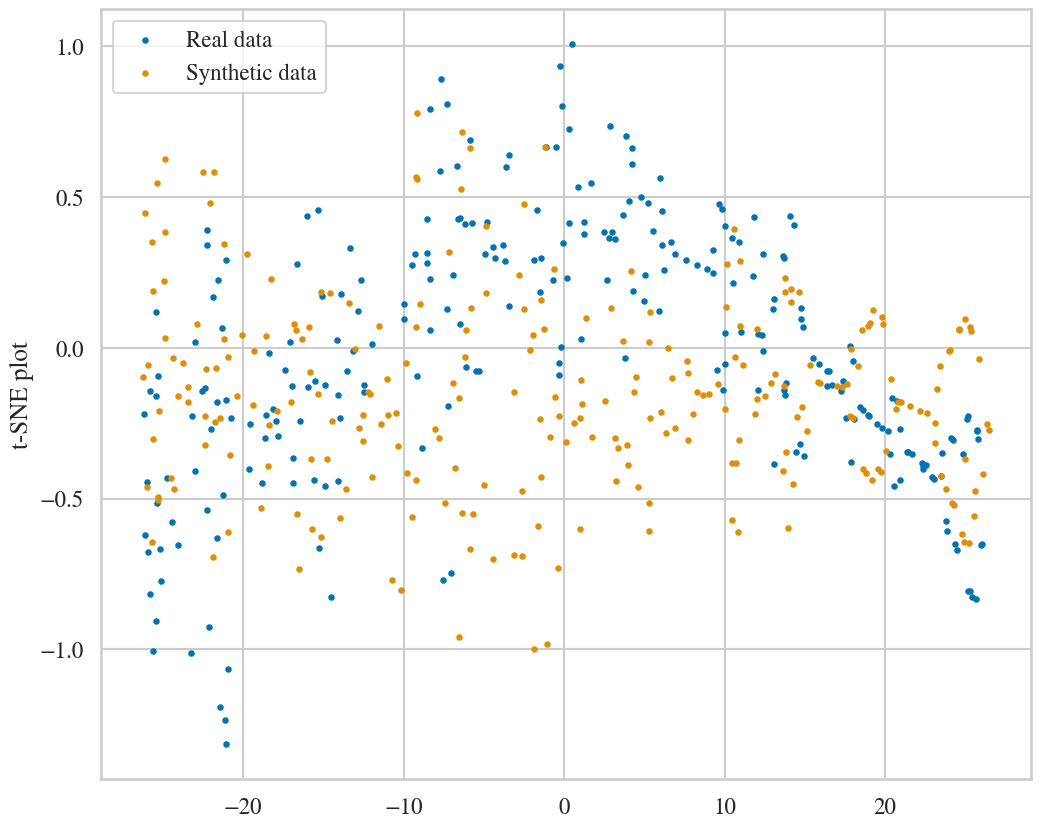

In [13]:
synthcity_dataloader_init = SurvivalAnalysisDataLoader(df_init_control, target_column = "censor", time_to_event_column = "time")
synthcity_dataloader_syn = SurvivalAnalysisDataLoader(df_gen_control_ext_sel, target_column = "censor", time_to_event_column = "time")
plot_tsne(plt, synthcity_dataloader_init, synthcity_dataloader_syn)

### 3.2. Statistical analysis: one generated control group vs. initial treated data

In [14]:
list_df_gen_control = []
for j in range(n_generated_dataset):
    df_gen_control_j = pd.DataFrame(data_gen_control[j].numpy(), columns=control_fnames)
    df_gen_control_j['treatment'] = 0
    list_df_gen_control.append(df_gen_control_j)

sel_idx = 0
df_gen_control_sel = list_df_gen_control[sel_idx]
df_syn_sel = pd.concat([df_init_treated, df_gen_control_sel], ignore_index=True)

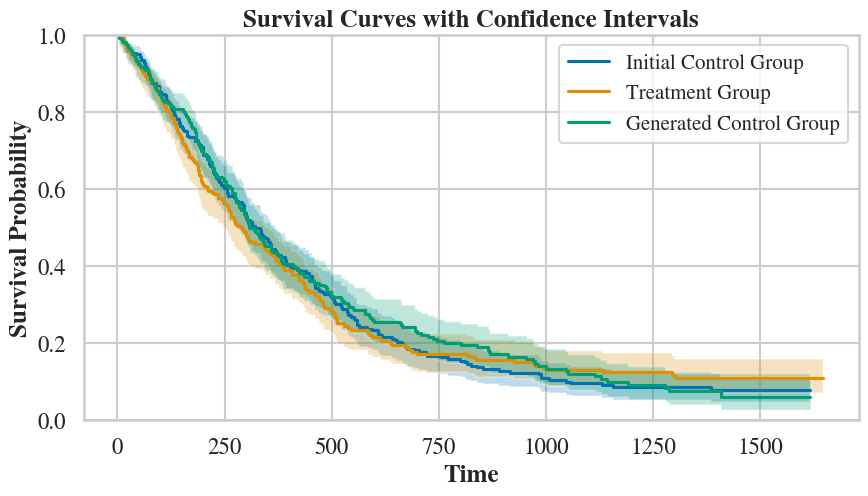

In [15]:
surv_time_control_init = df_init[df_init['treatment']==0].to_numpy()[:,0]
surv_ind_control_init = df_init[df_init['treatment']==0].to_numpy()[:,1].astype(bool)
surv_time_treated_init = df_init[df_init['treatment']==1].to_numpy()[:,0]
surv_ind_treated_init = df_init[df_init['treatment']==1].to_numpy()[:,1].astype(bool)
surv_time_control_gen = df_syn_sel[df_syn_sel['treatment']==0].to_numpy()[:,0]
surv_ind_control_gen = df_syn_sel[df_syn_sel['treatment']==0].to_numpy()[:,1].astype(bool)

uniq_time_control_init, surv_prob_control_init, conf_int_control_init = kaplan_meier_estimator(surv_ind_control_init, surv_time_control_init, conf_type="log-log")
uniq_time_treated_init, surv_prob_treated_init, conf_int_treated_init = kaplan_meier_estimator(surv_ind_treated_init, surv_time_treated_init, conf_type="log-log")
uniq_time_control_gen, surv_prob_control_gen, conf_int_control_gen = kaplan_meier_estimator(surv_ind_control_gen, surv_time_control_gen, conf_type="log-log")

plt.figure(figsize=(10, 5))
plt.step(uniq_time_control_init, surv_prob_control_init, where="post", label="Initial Control Group")
plt.fill_between(uniq_time_control_init, conf_int_control_init[0], conf_int_control_init[1], alpha=0.25, step="post")

plt.step(uniq_time_treated_init, surv_prob_treated_init, where="post", label="Treatment Group")
plt.fill_between(uniq_time_treated_init, conf_int_treated_init[0], conf_int_treated_init[1], alpha=0.25, step="post")

plt.step(uniq_time_control_gen, surv_prob_control_gen, where="post", label="Generated Control Group")
plt.fill_between(uniq_time_control_gen, conf_int_control_gen[0], conf_int_control_gen[1], alpha=0.25, step="post")

plt.ylim(0, 1)
plt.legend(fontsize=15)
plt.xlabel("Time", fontweight="semibold")
plt.ylabel("Survival Probability", fontweight="semibold")
plt.title("Survival Curves with Confidence Intervals", fontweight="bold")
plt.show()

In [16]:
table1 = TableOne(df_syn_sel, categorical=categorical, continuous=continuous, groupby='treatment', nonnormal=nonnormal, pval=True)
print(table1)

                         Grouped by treatment                                                                       
                                      Missing              Overall                    0                    1 P-Value
n                                                              520                  260                  260        
time, median [Q1,Q3]                        0  267.0 [135.2,496.5]  275.7 [167.3,522.2]  252.0 [119.2,480.5]   0.155
censor, n (%)        0.0                                111 (21.3)            55 (21.2)            56 (21.5)   1.000
                     1.0                                409 (78.7)           205 (78.8)           204 (78.5)        
SEX, n (%)           0.0                                 77 (14.8)            45 (17.3)            32 (12.3)   0.138
                     1.0                                443 (85.2)           215 (82.7)           228 (87.7)        
AGE, mean (SD)                              0           23.8 (7.

## 4. Testing

### 4.1. Univariate testing

In [17]:
from metrics import log_rank, cox_estimation

data_syn = []
for i in range(n_generated_dataset):
    df_gen_control = pd.DataFrame(data_gen_control[i].numpy(), columns=control_fnames)
    df_gen_control['treatment'] = 0
    data_syn.append(pd.concat([df_init_treated, df_gen_control], ignore_index=True))

LR_init, LR_syn = log_rank(df_init, data_syn)
coef_init, coef_syn, cox_p_value_init, cox_p_value_syn = cox_estimation(df_init, data_syn)

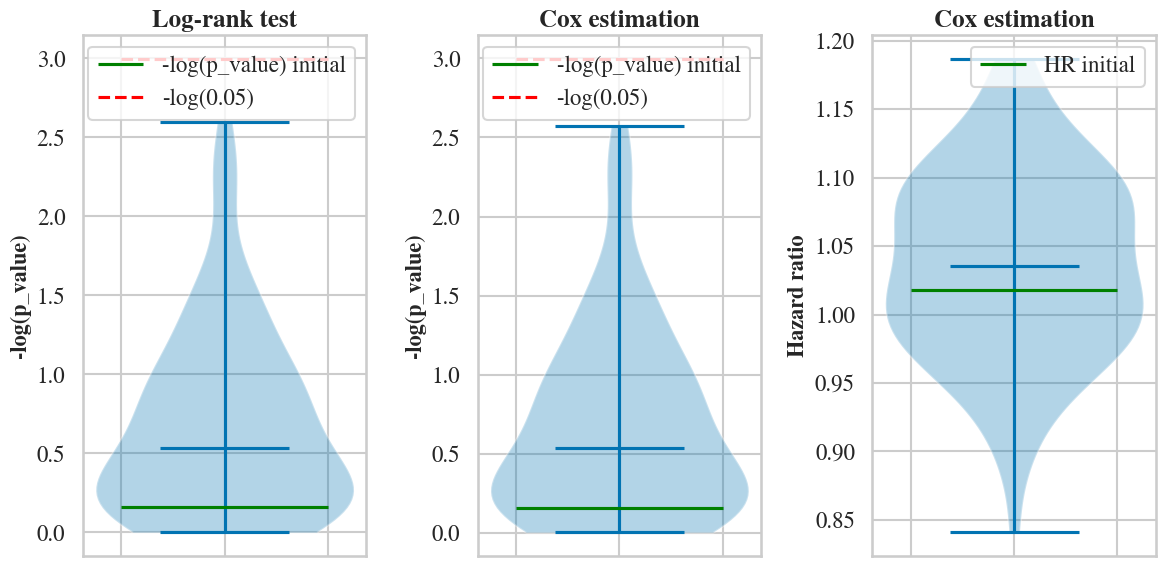

In [18]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].violinplot(LR_syn, showmeans=False, showmedians=True)   
axs[0].hlines(LR_init, 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[0].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[0].set_xticklabels('')
axs[0].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[0].set_title('Log-rank test', fontweight="bold", size=18)
axs[0].legend(loc='upper right')

axs[1].violinplot(-np.log(cox_p_value_syn), showmeans=False, showmedians=True)
axs[1].hlines(-np.log(cox_p_value_init), 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[1].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[1].set_title('Cox estimation', fontweight="bold", size=18)
axs[1].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[1].set_xticklabels('')
axs[1].legend(loc='upper right')

axs[2].violinplot(np.exp(coef_syn), showmeans=False, showmedians=True)
axs[2].hlines(np.exp(coef_init), 0.8, 1.2, color='green', label='HR initial')
axs[2].set_title('Cox estimation', fontweight="bold", size=18)
axs[2].set_ylabel('Hazard ratio', fontweight="semibold", size=16)
axs[2].set_xticklabels('')
axs[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

### 4.2. Stratified testing

#### 4.2.1. Categorical variable

In [19]:
from metrics import strata_log_rank, strata_cox_estimation

# Stratified w.r. karnof analysis
strata_var = 'SEX'
df_init_strata = df_init.copy(deep=True)
df_init_treated_strata = df_init_treated.copy(deep=True)

data_syn_strata = []
for i in range(n_generated_dataset):
    df_gen_control_strata = pd.DataFrame(data_gen_control[i].numpy(), columns=control_fnames)
    df_gen_control_strata['treatment'] = 0
    data_syn_strata.append(pd.concat([df_init_treated_strata, df_gen_control_strata], ignore_index=True))

strata_LR_init, strata_LR_syn = strata_log_rank(df_init_strata, data_syn_strata, strata=strata_var)
strata_coef_init, strata_coef_syn, strata_cox_p_value_init, strata_cox_p_value_syn = strata_cox_estimation(df_init_strata, data_syn_strata, strata=strata_var)

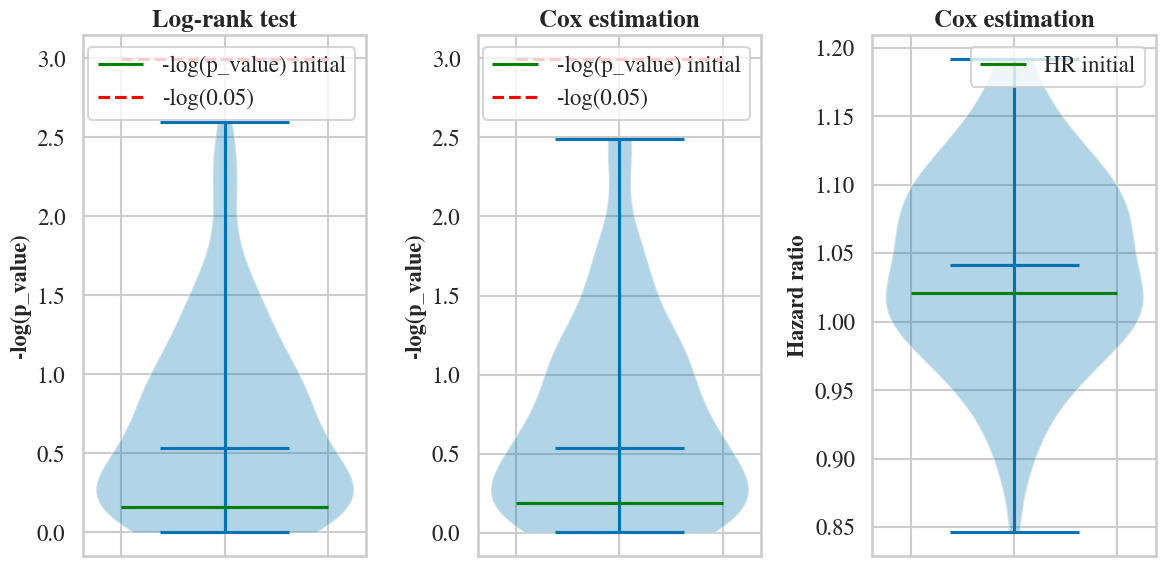

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(12, 6))

axs[0].violinplot(strata_LR_syn, showmeans=False, showmedians=True)   
axs[0].hlines(strata_LR_init, 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[0].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[0].set_xticklabels('')
axs[0].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[0].set_title('Log-rank test', fontweight="bold", size=18)
axs[0].legend(loc='upper right')

axs[1].violinplot(-np.log(strata_cox_p_value_syn), showmeans=False, showmedians=True)
axs[1].hlines(-np.log(strata_cox_p_value_init), 0.8, 1.2, color='green', label='-log(p_value) initial')
axs[1].hlines(-np.log(0.05), 0.8, 1.2, color='red', linestyle='--', label='-log(0.05)')
axs[1].set_title('Cox estimation', fontweight="bold", size=18)
axs[1].set_ylabel('-log(p_value)', fontweight="semibold", size=16)
axs[1].set_xticklabels('')
axs[1].legend(loc='upper right')

axs[2].violinplot(np.exp(strata_coef_syn), showmeans=False, showmedians=True)
axs[2].hlines(np.exp(strata_coef_init), 0.8, 1.2, color='green', label='HR initial')
axs[2].set_title('Cox estimation', fontweight="bold", size=18)
axs[2].set_ylabel('Hazard ratio', fontweight="semibold", size=16)
axs[2].set_xticklabels('')
axs[2].legend(loc='upper right')

plt.tight_layout()
plt.show()

### 4.3. Metrics form synthcity: initial control data vs. all generated synthetic control groups

In [21]:
# Set display options
pd.set_option('display.max_rows', None)      # Show all rows
pd.set_option('display.max_columns', None)   # Show all columns
pd.set_option('display.width', None)         # Prevent line wrapping
pd.set_option('display.max_colwidth', None)  # Show full content of each column

metrics = {
    'sanity': ['nearest_syn_neighbor_distance'],
    'stats': ['jensenshannon_dist', 'ks_test', 'survival_km_distance'],
    'performance': ['feat_rank_distance'],
    'detection': ['detection_xgb'],
    'privacy': ['k-map', 'distinct l-diversity', 'identifiability_score']
}
scores = ScoreEvaluator()
for j in range(n_generated_dataset):
    enable_reproducible_results(j)
    clear_cache()

    synthcity_dataloader_syn = SurvivalAnalysisDataLoader(list_df_gen_control[j], 
                                       target_column = "censor", 
                                       time_to_event_column = "time")

    evaluation = Metrics().evaluate(X_gt=synthcity_dataloader_init, # can be dataloaders or dataframes
                                    X_syn=synthcity_dataloader_syn, 
                                    reduction='mean', # default mean
                                    n_histogram_bins=10, # default 10
                                    metrics=metrics, # all metrics
                                    task_type='survival_analysis', 
                                    use_cache=True)

    mean_score = evaluation["mean"].to_dict()
    errors = evaluation["errors"].to_dict()
    duration = evaluation["durations"].to_dict()
    direction = evaluation["direction"].to_dict()

    for key in mean_score:
        scores.add(key, mean_score[key], errors[key], duration[key], direction[key])

synthcity_score = scores.to_dataframe()
synthcity_score

,min,max,mean,stddev,median,iqr,rounds,errors,durations,direction
sanity.nearest_syn_neighbor_distance.mean,0.041623,0.253883,0.115677,0.037091,0.109728,0.056459,100,0,0.00,minimize
stats.jensenshannon_dist.marginal,0.003145,0.007476,0.005042,0.000823,0.005017,0.001168,100,0,0.03,minimize
stats.ks_test.marginal,0.956643,0.978671,0.969091,0.004350,0.969231,0.005332,100,0,0.01,maximize
stats.survival_km_distance.optimism,-0.042028,0.049795,0.007345,0.018738,0.007734,0.031152,100,0,0.92,minimize
stats.survival_km_distance.abs_optimism,0.011571,0.050535,0.024647,0.008817,0.023864,0.012366,100,0,0.92,minimize
stats.survival_km_distance.sightedness,0.000000,0.167925,0.002444,0.018290,0.000000,0.000000,100,0,0.92,minimize
detection.detection_xgb.mean,0.720117,0.839624,0.779090,0.023346,0.776964,0.028943,100,0,0.18,minimize
privacy.k-map.score,1.000000,5.000000,2.470000,1.099591,2.000000,1.000000,100,0,0.03,maximize
privacy.distinct l-diversity.gt,4.000000,4.000000,4.000000,0.000000,4.000000,0.000000,100,0,0.07,maximize
privacy.distinct l-diversity.syn,1.000000,8.000000,3.380000,1.474992,3.000000,2.000000,100,0,0.07,maximize
